In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import os
import warnings
warnings.filterwarnings('ignore')

# Crear carpeta results si no existe
os.makedirs('results', exist_ok=True)

# Configuración
np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("=" * 80)
print("ASSIGNMENT UT3-10: PCA y Feature Selection - Ames Housing Dataset")
print("=" * 80)

# ========== FUNCIÓN DE CARGA Y PREPROCESAMIENTO RÁPIDO ==========
def quick_load_and_preprocess_ames(filepath='AmesHousing.csv'):
    """
    Carga y preprocesa Ames Housing en un solo paso
    (Ya hiciste esto en tareas anteriores, aquí es versión simplificada)
    """
    print("\n🏠 CARGANDO Y PREPROCESANDO AMES HOUSING...")

    # Cargar dataset
    df = pd.read_csv(filepath)
    print(f"✅ Dataset cargado: {df.shape[0]:,} casas, {df.shape[1]} columnas")

    # Eliminar 'Id' (no predictivo)
    df = df.drop('Id', axis=1, errors='ignore')

    # Identificar tipos de variables
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Remover target de features
    if 'SalePrice' in numerical_cols:
        numerical_cols.remove('SalePrice')

    print(f"✅ Features numéricas: {len(numerical_cols)}")
    print(f"✅ Features categóricas: {len(categorical_cols)}")

    # Imputar valores faltantes
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

    print(f"✅ Missing values imputados")

    # Label encoding para categóricas
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    print(f"✅ Categóricas encoded")

    # Separar X y y
    X = df.drop('SalePrice', axis=1)
    y = df['SalePrice']

    print(f"\n✅ DATASET LISTO:")
    print(f"   X shape: {X.shape} ({X.shape[1]} features)")
    print(f"   y shape: {y.shape}")
    print(f"   Precio promedio: ${y.mean():,.0f}")
    print(f"   Precio mediana: ${y.median():,.0f}")

    return X, y, X.columns.tolist()

# ========== EJECUTAR CARGA RÁPIDA ==========
X, y, feature_names = quick_load_and_preprocess_ames("data/AmesHousing.csv")

print(f"\n📊 RESUMEN DEL DATASET:")
print(f"   Total features: {X.shape[1]}")
print(f"   Total casas: {X.shape[0]:,}")
print(f"   Ejemplos de features: {feature_names[:10]}")

ASSIGNMENT UT3-10: PCA y Feature Selection - Ames Housing Dataset

🏠 CARGANDO Y PREPROCESANDO AMES HOUSING...
✅ Dataset cargado: 2,930 casas, 82 columnas
✅ Features numéricas: 38
✅ Features categóricas: 43
✅ Missing values imputados
✅ Categóricas encoded

✅ DATASET LISTO:
   X shape: (2930, 81) (81 features)
   y shape: (2930,)
   Precio promedio: $180,796
   Precio mediana: $160,000

📊 RESUMEN DEL DATASET:
   Total features: 81
   Total casas: 2,930
   Ejemplos de features: ['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour']


In [2]:
from sklearn.preprocessing import StandardScaler

# ========== ESTANDARIZACIÓN ==========
print("=== ESTANDARIZACIÓN DE FEATURES ===")
print("⚠️ PCA es sensible a escala. SIEMPRE estandarizar antes de PCA.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verificar estandarización: mean ≈ 0, std ≈ 1
print(f"\n✅ Mean después de scaling: {X_scaled.mean():.6f} (esperado: ~0)")
print(f"✅ Std después de scaling: {X_scaled.std():.6f} (esperado: ~1)")

# Verificar shape
print(f"✅ X_scaled shape: {X_scaled.shape}")

# Comparar antes vs después
print(f"\n=== COMPARACIÓN ANTES vs DESPUÉS ===")
print(f"Antes - Mean GrLivArea: {X['Gr Liv Area'].mean():.0f}, Std: {X['Gr Liv Area'].std():.0f}")
print(f"Después - Mean GrLivArea: {X_scaled[:, X.columns.get_loc('Gr Liv Area')].mean():.6f}, Std: {X_scaled[:, X.columns.get_loc('Gr Liv Area')].std():.6f}")

=== ESTANDARIZACIÓN DE FEATURES ===
⚠️ PCA es sensible a escala. SIEMPRE estandarizar antes de PCA.



✅ Mean después de scaling: -0.000000 (esperado: ~0)
✅ Std después de scaling: 1.000000 (esperado: ~1)
✅ X_scaled shape: (2930, 81)

=== COMPARACIÓN ANTES vs DESPUÉS ===
Antes - Mean GrLivArea: 1500, Std: 506
Después - Mean GrLivArea: 0.000000, Std: 1.000000


In [3]:
from sklearn.decomposition import PCA
import time

# ========== APLICAR PCA SIN RESTRICCIONES ==========
print("\n=== APLICANDO PCA ===")
print("⏱️ Esto puede tomar 10-20 segundos con 80 features...")

start_time = time.time()

pca = PCA()  # Sin n_components = todos los componentes posibles
X_pca = pca.fit_transform(X_scaled)

elapsed_time = time.time() - start_time
print(f"✅ PCA completado en {elapsed_time:.2f} segundos")

# ========== ANALIZAR VARIANZA EXPLICADA ==========
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n=== ANÁLISIS DE COMPONENTES PRINCIPALES ===")
print(f"Total de componentes generados: {pca.n_components_}")
print(f"\nVarianza explicada por componentes principales:")
print(f"  PC1: {explained_variance[0]:.3%} (¡la más importante!)")
print(f"  PC2: {explained_variance[1]:.3%}")
print(f"  PC3: {explained_variance[2]:.3%}")
print(f"  PC4: {explained_variance[3]:.3%}")
print(f"  PC5: {explained_variance[4]:.3%}")

print("\n=== TOP 10 COMPONENTES ===")
for i in range(min(10, len(explained_variance))):
    print(f"PC{i+1:2d}: Individual {explained_variance[i]:6.3%} | Acumulada {cumulative_variance[i]:6.3%}")


=== APLICANDO PCA ===
⏱️ Esto puede tomar 10-20 segundos con 80 features...
✅ PCA completado en 0.07 segundos

=== ANÁLISIS DE COMPONENTES PRINCIPALES ===
Total de componentes generados: 81

Varianza explicada por componentes principales:
  PC1: 13.409% (¡la más importante!)
  PC2: 4.956%
  PC3: 4.709%
  PC4: 3.690%
  PC5: 2.974%

=== TOP 10 COMPONENTES ===
PC 1: Individual 13.409% | Acumulada 13.409%
PC 2: Individual 4.956% | Acumulada 18.365%
PC 3: Individual 4.709% | Acumulada 23.074%
PC 4: Individual 3.690% | Acumulada 26.765%
PC 5: Individual 2.974% | Acumulada 29.739%
PC 6: Individual 2.727% | Acumulada 32.466%
PC 7: Individual 2.550% | Acumulada 35.017%
PC 8: Individual 2.404% | Acumulada 37.420%
PC 9: Individual 2.239% | Acumulada 39.659%
PC10: Individual 2.121% | Acumulada 41.780%



=== SCREE PLOT: VISUALIZACIÓN DE VARIANZA ===


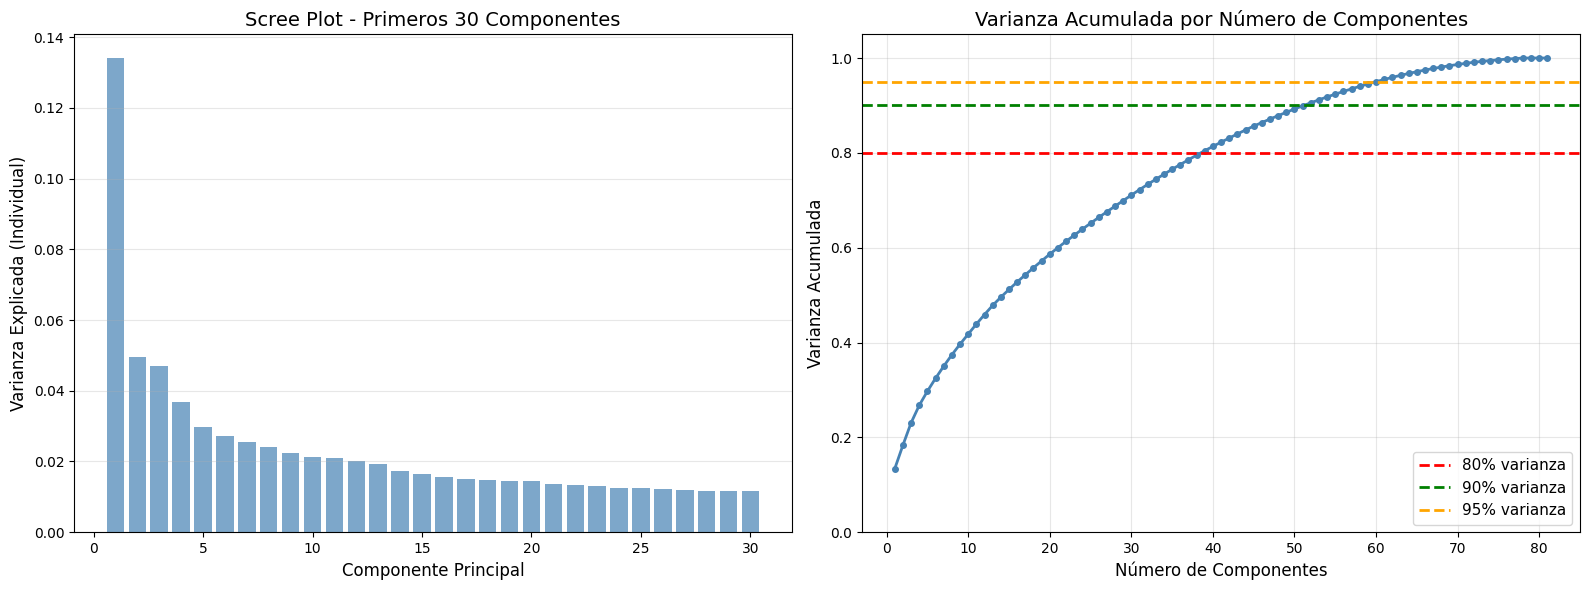


=== DECISIÓN: ¿CUÁNTOS COMPONENTES NECESITAMOS? ===
📊 Para 80% de varianza: 38 componentes
📊 Para 90% de varianza: 51 componentes
📊 Para 95% de varianza: 59 componentes

🎯 IMPACTO DE REDUCCIÓN DIMENSIONAL:
   Original: 81 features
   80% varianza: 81 → 38 (53.1% reducción)
   90% varianza: 81 → 51 (37.0% reducción)
   95% varianza: 81 → 59 (27.2% reducción)

💡 RECOMENDACIÓN PRÁCTICA:
   Para este assignment, usaremos 38 componentes (80% varianza)
   Esto balancea reducción dimensional con retención de información


In [4]:
# ========== CREAR SCREE PLOT ==========
print("\n=== SCREE PLOT: VISUALIZACIÓN DE VARIANZA ===")

plt.figure(figsize=(16, 6))

# Subplot 1: Varianza individual (primeros 30 componentes para claridad)
plt.subplot(1, 2, 1)
n_to_show = min(30, len(explained_variance))
plt.bar(range(1, n_to_show + 1), explained_variance[:n_to_show], alpha=0.7, color='steelblue')
plt.xlabel('Componente Principal', fontsize=12)
plt.ylabel('Varianza Explicada (Individual)', fontsize=12)
plt.title(f'Scree Plot - Primeros {n_to_show} Componentes', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Subplot 2: Varianza acumulada (TODOS los componentes)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', 
         color='steelblue', markersize=4, linewidth=2)

# Líneas de referencia
plt.axhline(y=0.80, color='r', linestyle='--', label='80% varianza', linewidth=2)
plt.axhline(y=0.90, color='g', linestyle='--', label='90% varianza', linewidth=2)
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% varianza', linewidth=2)

plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada', fontsize=12)
plt.title('Varianza Acumulada por Número de Componentes', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.ylim([0, 1.05])

plt.tight_layout()
plt.savefig('results/scree_plot.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== DECISIÓN DE DIMENSIONALIDAD ==========
print("\n=== DECISIÓN: ¿CUÁNTOS COMPONENTES NECESITAMOS? ===")
n_components_80 = np.argmax(cumulative_variance >= 0.80) 
n_components_90 = np.argmax(cumulative_variance >= 0.90)
n_components_95 = np.argmax(cumulative_variance >= 0.95) 

print(f"📊 Para 80% de varianza: {n_components_80} componentes")
print(f"📊 Para 90% de varianza: {n_components_90} componentes")
print(f"📊 Para 95% de varianza: {n_components_95} componentes")

# Análisis de reducción dimensional
original_features = X.shape[1]
reduction_80 = (1 - n_components_80 / original_features) * 100
reduction_90 = (1 - n_components_90 / original_features) * 100
reduction_95 = (1 - n_components_95 / original_features) * 100

print(f"\n🎯 IMPACTO DE REDUCCIÓN DIMENSIONAL:")
print(f"   Original: {original_features} features")
print(f"   80% varianza: {original_features} → {n_components_80} ({reduction_80:.1f}% reducción)")
print(f"   90% varianza: {original_features} → {n_components_90} ({reduction_90:.1f}% reducción)")
print(f"   95% varianza: {original_features} → {n_components_95} ({reduction_95:.1f}% reducción)")

print(f"\n💡 RECOMENDACIÓN PRÁCTICA:")
print(f"   Para este assignment, usaremos {n_components_80} componentes (80% varianza)")
print(f"   Esto balancea reducción dimensional con retención de información")


=== FEATURE SELECTION BASADA EN PCA LOADINGS ===
💡 En lugar de usar PC1, PC2... usaremos las features ORIGINALES
   que tienen mayor loading (peso) en los componentes principales

🔍 Analizando loadings de los primeros 2 componentes...

📊 ESTRATEGIA: Ranking de features por suma de loadings absolutos

🔝 TOP 20 FEATURES POR IMPORTANCIA EN PCA:
   1. Gr Liv Area              : 0.4494
   2. TotRms AbvGrd            : 0.4431
   3. 2nd Flr SF               : 0.4354
   4. BsmtFin SF 1             : 0.3946
   5. Full Bath                : 0.3841
   6. Bsmt Full Bath           : 0.3415
   7. Year Built               : 0.3399
   8. Bedroom AbvGr            : 0.3335
   9. Total Bsmt SF            : 0.3159
  10. BsmtFin Type 1           : 0.3014
  11. Half Bath                : 0.2913
  12. Overall Qual             : 0.2847
  13. Bsmt Unf SF              : 0.2821
  14. 1st Flr SF               : 0.2728
  15. Bsmt Exposure            : 0.2628
  16. Garage Type              : 0.2559
  17. Garage Yr

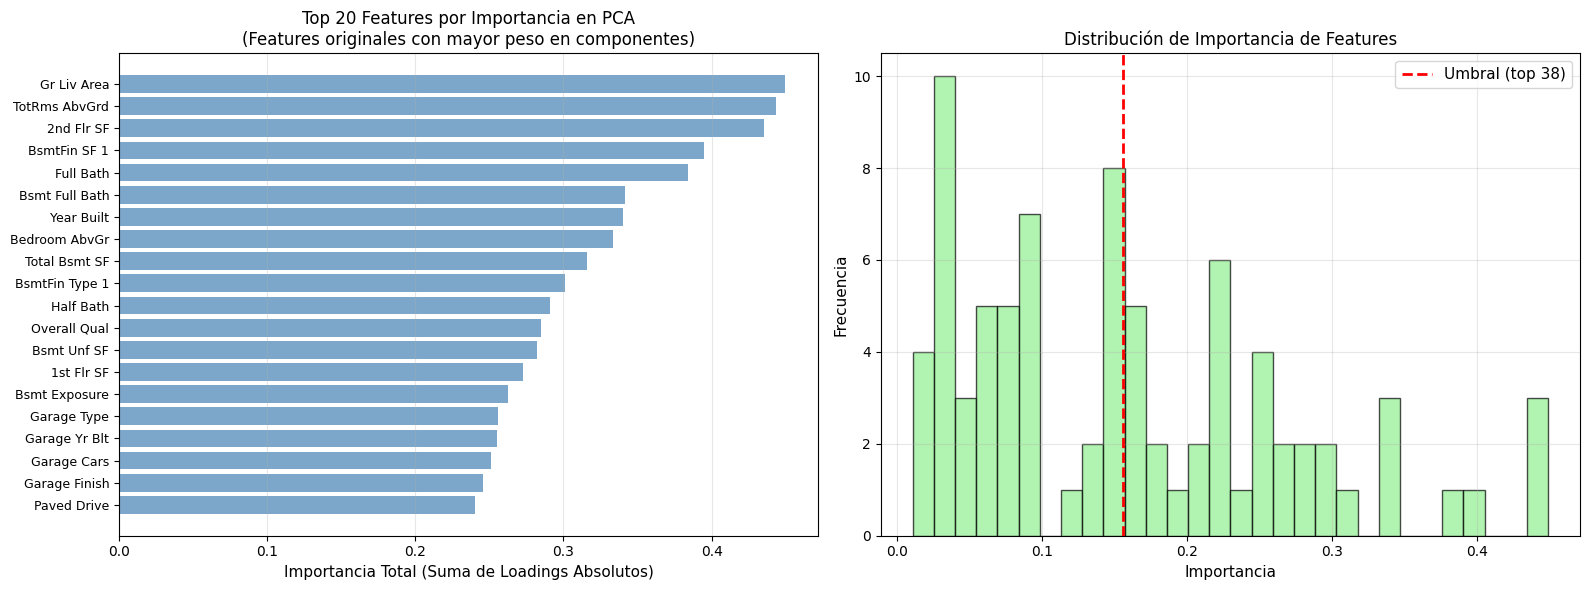


💡 INTERPRETACIÓN:
   Estas features originales son las que 'explican' los componentes principales
   Ventaja: Mantienen interpretabilidad (puedes decir 'GrLivArea importa')
   Diferencia con PCA: Usas features originales, no combinaciones lineales


In [5]:
# ========== FEATURE SELECTION BASADA EN PCA LOADINGS ==========
print("\n=== FEATURE SELECTION BASADA EN PCA LOADINGS ===")
print("💡 En lugar de usar PC1, PC2... usaremos las features ORIGINALES")
print("   que tienen mayor loading (peso) en los componentes principales")

# Decidir cuántos componentes considerar
n_top_components = 2

# Obtener loadings absolutos de todos los componentes importantes
print(f"\n🔍 Analizando loadings de los primeros {n_top_components} componentes...")

# Para cada componente, obtener las features con mayor loading absoluto
all_loadings = pca.components_[:n_top_components, :]  # Primeros n componentes

# Crear DataFrame con loadings de todos los componentes
loadings_all = pd.DataFrame(
    all_loadings.T,
    columns=[f'PC{i+1}' for i in range(n_top_components)],
    index=X.columns
)

# ========== ESTRATEGIA: SUMAR LOADINGS ABSOLUTOS ==========
# Para cada feature, sumar su importancia (loading absoluto) en todos los componentes
print("\n📊 ESTRATEGIA: Ranking de features por suma de loadings absolutos")

feature_importance_from_pca = loadings_all.abs().sum(axis=1)

# Ordenar por importancia
feature_importance_from_pca = feature_importance_from_pca.sort_values(ascending=False)

print(f"\n🔝 TOP 20 FEATURES POR IMPORTANCIA EN PCA:")
for i, (feature, importance) in enumerate(feature_importance_from_pca.head(20).items(), 1):
    print(f"  {i:2d}. {feature:25s}: {importance:.4f}")

# ========== SELECCIONAR TOP-K FEATURES ==========
k = n_components_80  # Mismo número que usamos con PCA reducido

print(f"\n✅ Seleccionando top {k} features originales basadas en loadings de PCA")

selected_features_pca = feature_importance_from_pca.head(k).index.tolist()

print(f"\n📋 Features seleccionadas ({k}):")
for i, feat in enumerate(selected_features_pca, 1):
    print(f"  {i:2d}. {feat}")

# ========== PREPARAR DATASET CON FEATURES SELECCIONADAS ==========
X_pca_selected = X_scaled[:, X.columns.isin(selected_features_pca)]

print(f"\n✅ Dataset con features seleccionadas por PCA:")
print(f"   Shape: {X_pca_selected.shape}")
print(f"   Reducción: {X.shape[1]} → {X_pca_selected.shape[1]} features")

# ========== VISUALIZAR COMPARACIÓN ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features por importancia PCA
ax1.barh(range(20), feature_importance_from_pca.head(20).values, color='steelblue', alpha=0.7)
ax1.set_yticks(range(20))
ax1.set_yticklabels(feature_importance_from_pca.head(20).index, fontsize=9)
ax1.set_xlabel('Importancia Total (Suma de Loadings Absolutos)', fontsize=11)
ax1.set_title('Top 20 Features por Importancia en PCA\n(Features originales con mayor peso en componentes)', fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Distribución de importancias
ax2.hist(feature_importance_from_pca, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Importancia', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.set_title('Distribución de Importancia de Features', fontsize=12)
ax2.axvline(feature_importance_from_pca.iloc[k-1], color='red', linestyle='--', 
            label=f'Umbral (top {k})', linewidth=2)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/pca_loadings_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("   Estas features originales son las que 'explican' los componentes principales")
print("   Ventaja: Mantienen interpretabilidad (puedes decir 'GrLivArea importa')")
print("   Diferencia con PCA: Usas features originales, no combinaciones lineales")

In [6]:
from sklearn.ensemble import RandomForestRegressor  # ⚠️ REGRESSOR, no Classifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')  # Suprimir warnings de convergencia

# ========== MODELO BASELINE: TODAS LAS FEATURES ORIGINALES ==========
print("\n=== EVALUACIÓN DE PERFORMANCE: PCA vs ORIGINAL ===")
print("⏱️ Esto puede tomar 1-2 minutos (cross-validation con 80 features)...\n")

print("🔄 Evaluando modelo con features originales...")
rf_original = RandomForestRegressor(
    random_state=42, 
    n_estimators=2000,
    max_depth=None,
    n_jobs=-1             # Usar todos los cores
)

# Usar neg_mean_squared_error y neg_mean_absolute_error para CV
scores_mse_original = -cross_val_score(rf_original, X_scaled, y, cv=5, 
                                        scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_original = cross_val_score(rf_original, X_scaled, y, cv=5, 
                                     scoring='r2', n_jobs=-1)

rmse_original = np.sqrt(scores_mse_original)

print(f"\n✅ BASELINE - Features Originales ({X.shape[1]} features):")
print(f"   RMSE: ${rmse_original.mean():,.0f} ± ${rmse_original.std():,.0f}")
print(f"   R²:   {scores_r2_original.mean():.4f} ± {scores_r2_original.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_original]}")

# ========== MODELO CON PCA (80% VARIANZA) ==========
print(f"\n🔄 Evaluando modelo con PCA ({n_components_80} componentes)...")

pca_reduced = PCA(n_components= n_components_80)
X_pca_reduced = pca_reduced.fit_transform(X_scaled)

print(f"✅ PCA transformado: {X.shape[1]} → {X_pca_reduced.shape[1]} features")

# Evaluar con PCA
rf_pca = RandomForestRegressor(
    random_state=42, 
    n_estimators=100, 
    max_depth=15,
    n_jobs=-1
)

scores_mse_pca = -cross_val_score(rf_pca, X_pca_reduced, y, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_pca = cross_val_score(rf_pca, X_pca_reduced, y, cv=5, 
                                scoring='r2', n_jobs=-1)

rmse_pca = np.sqrt(scores_mse_pca)

print(f"\n✅ PCA - Componentes Reducidos ({n_components_80} componentes):")
print(f"   RMSE: ${rmse_pca.mean():,.0f} ± ${rmse_pca.std():,.0f}")
print(f"   R²:   {scores_r2_pca.mean():.4f} ± {scores_r2_pca.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_pca]}")

# ========== MODELO CON FEATURES SELECCIONADAS POR PCA LOADINGS ==========
print(f"\n🔄 Evaluando modelo con features originales seleccionadas por PCA loadings...")

rf_pca_selected = RandomForestRegressor(
    random_state=42, 
    n_estimators=100, 
    max_depth=15,
    n_jobs=-1
)

scores_mse_pca_selected = -cross_val_score(rf_pca_selected, X_pca_selected, y, cv=5, 
                                             scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_pca_selected = cross_val_score(rf_pca_selected, X_pca_selected, y, cv=5, 
                                          scoring='r2', n_jobs=-1)

rmse_pca_selected = np.sqrt(scores_mse_pca_selected)

print(f"\n✅ PCA Loadings - Features Originales Seleccionadas ({len(selected_features_pca)} features):")
print(f"   RMSE: ${rmse_pca_selected.mean():,.0f} ± ${rmse_pca_selected.std():,.0f}")
print(f"   R²:   {scores_r2_pca_selected.mean():.4f} ± {scores_r2_pca_selected.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_pca_selected]}")

# ========== ANÁLISIS COMPARATIVO ==========
print(f"\n" + "="*80)
print(f"{'COMPARACIÓN: ORIGINAL vs PCA vs PCA LOADINGS':^80}")
print(f"="*80)

reduction_pct = (1 - n_components_80 / X.shape[1]) * 100
rmse_diff_pca = rmse_pca.mean() - rmse_original.mean()
rmse_diff_pca_selected = rmse_pca_selected.mean() - rmse_original.mean()
r2_diff_pca = scores_r2_pca.mean() - scores_r2_original.mean()
r2_diff_pca_selected = scores_r2_pca_selected.mean() - scores_r2_original.mean()

print(f"\n📊 REDUCCIÓN DIMENSIONAL:")
print(f"   Original: {X.shape[1]} features")
print(f"   PCA: {X.shape[1]} → {n_components_80} componentes ({reduction_pct:.1f}% reducción)")
print(f"   PCA Loadings: {X.shape[1]} → {len(selected_features_pca)} features originales ({reduction_pct:.1f}% reducción)")
print(f"   Varianza retenida (PCA): {pca_reduced.explained_variance_ratio_.sum():.1%}")

print(f"\n📊 PERFORMANCE COMPARATIVO:")
print(f"\n   {'Método':<25s} {'RMSE':>15s} {'R²':>10s} {'Features':>10s}")
print(f"   {'-'*25} {'-'*15} {'-'*10} {'-'*10}")
print(f"   {'Original':<25s} ${rmse_original.mean():>14,.0f} {scores_r2_original.mean():>10.4f} {X.shape[1]:>10d}")
print(f"   {'PCA Componentes':<25s} ${rmse_pca.mean():>14,.0f} {scores_r2_pca.mean():>10.4f} {n_components_80:>10d}")
print(f"   {'PCA Loadings (Originales)':<25s} ${rmse_pca_selected.mean():>14,.0f} {scores_r2_pca_selected.mean():>10.4f} {len(selected_features_pca):>10d}")

print(f"\n📊 DIFERENCIAS VS ORIGINAL:")
print(f"   PCA Componentes:  RMSE {rmse_diff_pca:+,.0f} ({(rmse_diff_pca/rmse_original.mean())*100:+.1f}%) | R² {r2_diff_pca:+.4f}")
print(f"   PCA Loadings:     RMSE {rmse_diff_pca_selected:+,.0f} ({(rmse_diff_pca_selected/rmse_original.mean())*100:+.1f}%) | R² {r2_diff_pca_selected:+.4f}")

# Interpretación
print(f"\n💡 INTERPRETACIÓN:")
print(f"\n   🔵 PCA Componentes (PC1, PC2...):")
if rmse_pca.mean() < rmse_original.mean() * 1.05:
    print(f"      ✅ Mantiene performance similar con {reduction_pct:.0f}% reducción")
    print(f"      ⚠️ Pero: Componentes son combinaciones lineales (menos interpretables)")
else:
    print(f"      ⚠️ Pierde precisión significativa ({(rmse_diff_pca/rmse_original.mean())*100:.1f}%)")

print(f"\n   🟢 PCA Loadings (Features originales):")
if rmse_pca_selected.mean() < rmse_original.mean() * 1.05:
    print(f"      ✅ Mantiene performance similar con {reduction_pct:.0f}% reducción")
    print(f"      ✅ Plus: Usa features originales (interpretables)")
else:
    print(f"      ⚠️ Pierde precisión ({(rmse_diff_pca_selected/rmse_original.mean())*100:.1f}%)")

print(f"\n   💼 PARA NEGOCIO:")
print(f"      - PCA Componentes: Mejor para modelos 'black box' donde solo importa precisión")
print(f"      - PCA Loadings: Mejor para negocio (puedes decir 'GrLivArea es importante')")


=== EVALUACIÓN DE PERFORMANCE: PCA vs ORIGINAL ===
⏱️ Esto puede tomar 1-2 minutos (cross-validation con 80 features)...

🔄 Evaluando modelo con features originales...

✅ BASELINE - Features Originales (81 features):
   RMSE: $26,342 ± $4,353
   R²:   0.8885 ± 0.0311
   Scores RMSE: ['$27,351', '$20,403', '$27,453', '$33,249', '$23,254']

🔄 Evaluando modelo con PCA (38 componentes)...
✅ PCA transformado: 81 → 38 features

✅ PCA - Componentes Reducidos (38 componentes):
   RMSE: $26,620 ± $4,082
   R²:   0.8859 ± 0.0317
   Scores RMSE: ['$25,613', '$22,127', '$27,048', '$34,109', '$24,202']

🔄 Evaluando modelo con features originales seleccionadas por PCA loadings...

✅ PCA Loadings - Features Originales Seleccionadas (38 features):
   RMSE: $27,020 ± $4,051
   R²:   0.8830 ± 0.0295
   Scores RMSE: ['$27,912', '$21,642', '$28,373', '$33,361', '$23,812']

                  COMPARACIÓN: ORIGINAL vs PCA vs PCA LOADINGS                  

📊 REDUCCIÓN DIMENSIONAL:
   Original: 81 features
 


=== FILTER METHOD: F-TEST (ANOVA) ===
F-test mide la relación lineal entre cada feature y el target (SalePrice)

Seleccionando top 38 features con F-test...

✅ Features seleccionadas por F-test (38):
   1. PID
   2. Lot Frontage
   3. Lot Area
   4. Lot Shape
   5. Neighborhood
   6. Overall Qual
   7. Year Built
   8. Year Remod/Add
   9. Roof Style
  10. Mas Vnr Type
  11. Mas Vnr Area
  12. Exter Qual
  13. Foundation
  14. Bsmt Qual
  15. Bsmt Exposure
  16. BsmtFin SF 1
  17. Total Bsmt SF
  18. Heating QC
  19. Central Air
  20. Electrical
  21. 1st Flr SF
  22. 2nd Flr SF
  23. Gr Liv Area
  24. Bsmt Full Bath
  25. Full Bath
  26. Half Bath
  27. Kitchen Qual
  28. TotRms AbvGrd
  29. Fireplaces
  30. Garage Type
  31. Garage Yr Blt
  32. Garage Finish
  33. Garage Cars
  34. Garage Area
  35. Paved Drive
  36. Wood Deck SF
  37. Open Porch SF
  38. Sale Condition

=== TOP 15 F-SCORES (Mayor correlación con SalePrice) ===
   1. Overall Qual        : 5,179
   2. Gr Liv Area    

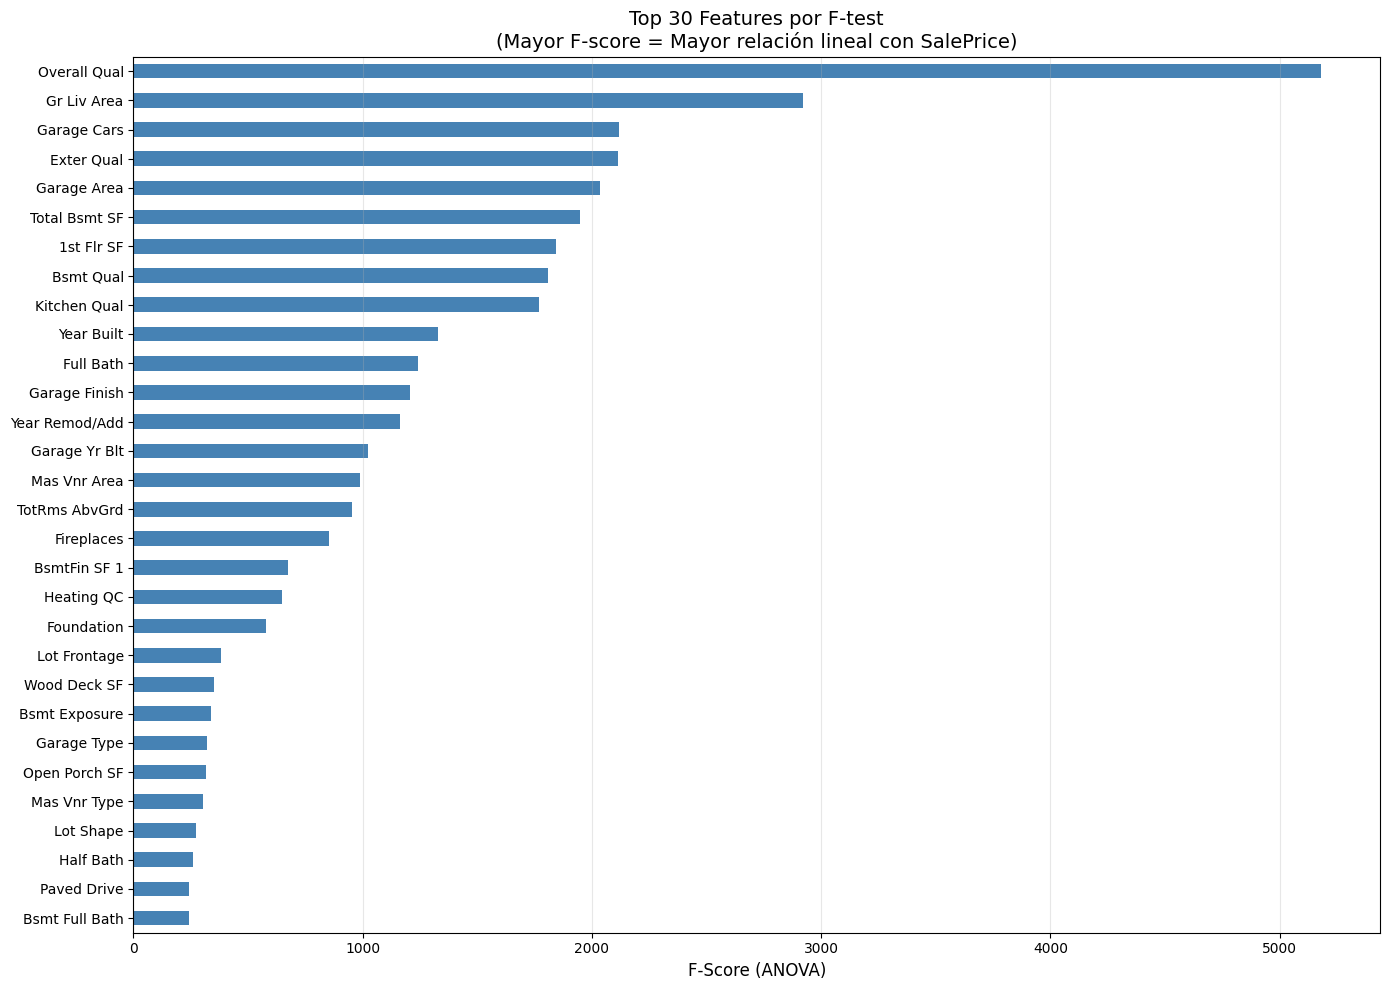


🔄 Evaluando F-test...
✅ F-test (38 features):
   RMSE: $26,395 ± $4,083
   R²:   0.8883 ± 0.0289

=== FILTER METHOD: MUTUAL INFORMATION ===
Mutual Information mide dependencia no-lineal entre features y target

Seleccionando top 38 features con Mutual Information...

✅ Features seleccionadas por MI (38):
   1. Order
   2. PID
   3. MS SubClass
   4. MS Zoning
   5. Lot Frontage
   6. Lot Area
   7. Neighborhood
   8. Overall Qual
   9. Overall Cond
  10. Year Built
  11. Year Remod/Add
  12. Exterior 1st
  13. Exterior 2nd
  14. Mas Vnr Area
  15. Exter Qual
  16. Foundation
  17. Bsmt Qual
  18. BsmtFin Type 1
  19. BsmtFin SF 1
  20. Bsmt Unf SF
  21. Total Bsmt SF
  22. Heating QC
  23. 1st Flr SF
  24. 2nd Flr SF
  25. Gr Liv Area
  26. Full Bath
  27. Kitchen Qual
  28. TotRms AbvGrd
  29. Fireplaces
  30. Fireplace Qu
  31. Garage Type
  32. Garage Yr Blt
  33. Garage Finish
  34. Garage Cars
  35. Garage Area
  36. Wood Deck SF
  37. Open Porch SF
  38. Sale Type

=== TOP 15 MI

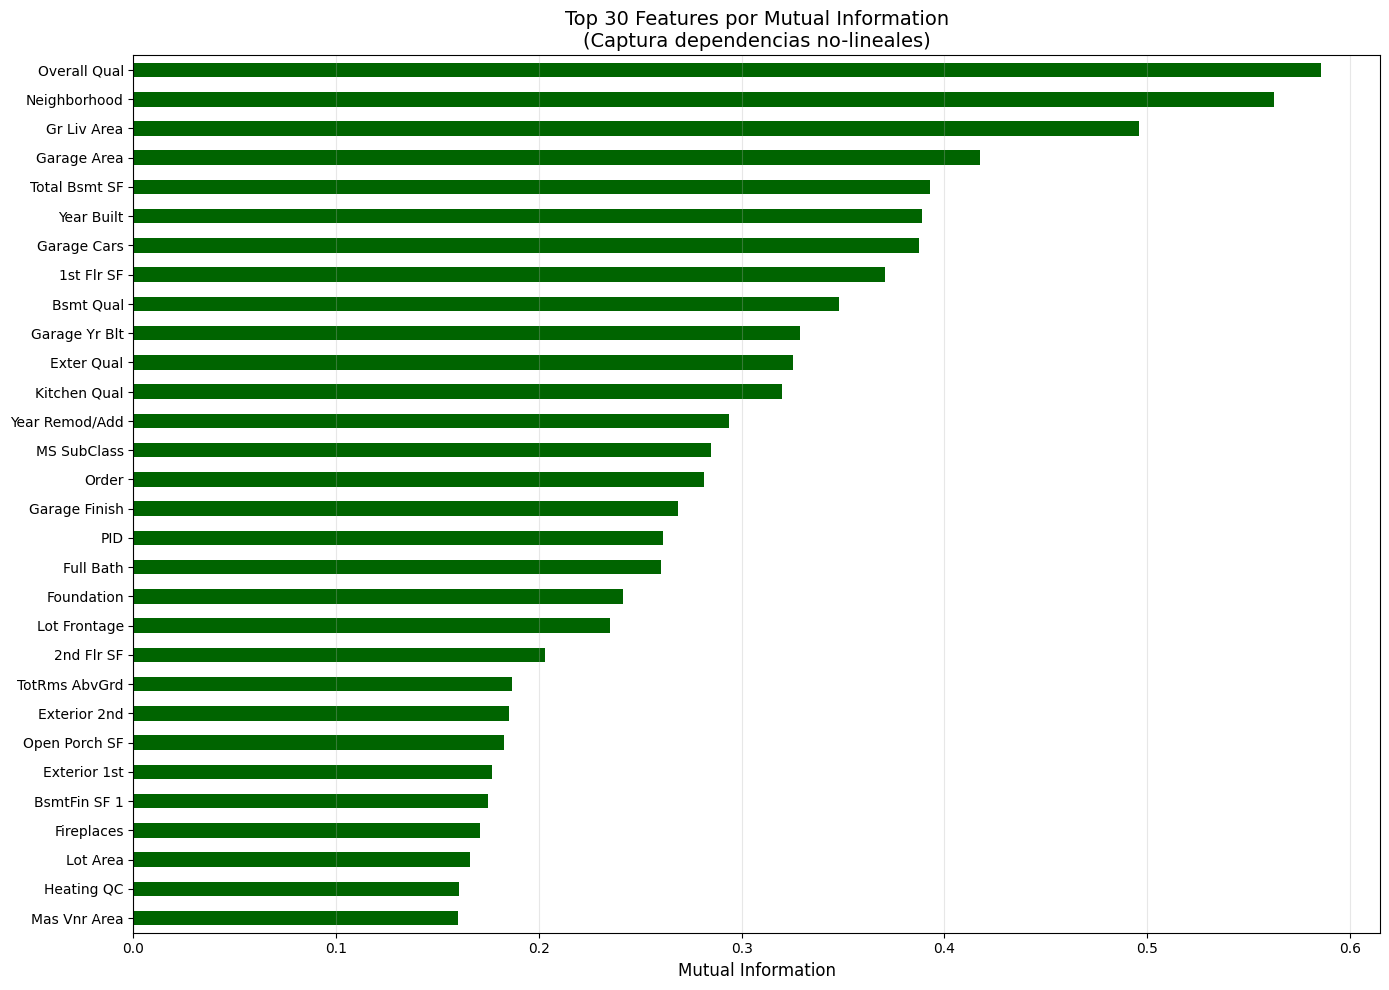


🔄 Evaluando Mutual Information...
✅ MI (38 features):
   RMSE: $26,279 ± $4,281
   R²:   0.8891 ± 0.0305


In [7]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# ========== F-TEST PARA REGRESIÓN ==========
print("\n=== FILTER METHOD: F-TEST (ANOVA) ===")
print("F-test mide la relación lineal entre cada feature y el target (SalePrice)")

k = n_components_80  # Mismo número que PCA para comparación justa

print(f"\nSeleccionando top {k} features con F-test...")

selector_f = SelectKBest(score_func=f_regression, k=k)
X_filter_f = selector_f.fit_transform(X_scaled, y)

# Identificar features seleccionadas
selected_features_f = X.columns[selector_f.get_support()]
print(f"\n✅ Features seleccionadas por F-test ({k}):")
for i, feat in enumerate(selected_features_f, 1):
    print(f"  {i:2d}. {feat}")

# ========== SCORES DE F-TEST ==========
scores_f = pd.Series(selector_f.scores_, index=X.columns).sort_values(ascending=False)
print(f"\n=== TOP 15 F-SCORES (Mayor correlación con SalePrice) ===")
for i, (feat, score) in enumerate(scores_f.head(15).items(), 1):
    print(f"  {i:2d}. {feat:20s}: {score:,.0f}")

# Visualizar scores (top 30 para claridad)
plt.figure(figsize=(14, 10))
scores_f.head(30).sort_values(ascending=True).plot(kind='barh', color='steelblue')
plt.xlabel('F-Score (ANOVA)', fontsize=12)
plt.title('Top 30 Features por F-test\n(Mayor F-score = Mayor relación lineal con SalePrice)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('results/f_test_scores.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== EVALUAR F-TEST ==========
print(f"\n🔄 Evaluando F-test...")
rf_filter_f = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)
scores_mse_filter_f = -cross_val_score(rf_filter_f, X_filter_f, y, cv=5, 
                                        scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_filter_f = cross_val_score(rf_filter_f, X_filter_f, y, cv=5, 
                                      scoring='r2', n_jobs=-1)
rmse_filter_f = np.sqrt(scores_mse_filter_f)

print(f"✅ F-test ({k} features):")
print(f"   RMSE: ${rmse_filter_f.mean():,.0f} ± ${rmse_filter_f.std():,.0f}")
print(f"   R²:   {scores_r2_filter_f.mean():.4f} ± {scores_r2_filter_f.std():.4f}")

# ========== MUTUAL INFORMATION ==========
print("\n=== FILTER METHOD: MUTUAL INFORMATION ===")
print("Mutual Information mide dependencia no-lineal entre features y target")

print(f"\nSeleccionando top {k} features con Mutual Information...")

selector_mi = SelectKBest(score_func=mutual_info_regression, k=k)
X_filter_mi = selector_mi.fit_transform(X_scaled, y)

selected_features_mi = X.columns[selector_mi.get_support()]
print(f"\n✅ Features seleccionadas por MI ({k}):")
for i, feat in enumerate(selected_features_mi, 1):
    print(f"  {i:2d}. {feat}")

scores_mi = pd.Series(selector_mi.scores_, index=X.columns).sort_values(ascending=False)
print(f"\n=== TOP 15 MI SCORES ===")
for i, (feat, score) in enumerate(scores_mi.head(15).items(), 1):
    print(f"  {i:2d}. {feat:20s}: {score:.4f}")

# Visualizar
plt.figure(figsize=(14, 10))
scores_mi.head(30).sort_values(ascending=True).plot(kind='barh', color='darkgreen')
plt.xlabel('Mutual Information', fontsize=12)
plt.title('Top 30 Features por Mutual Information\n(Captura dependencias no-lineales)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('results/mutual_information_scores.png', dpi=150, bbox_inches='tight')
plt.show()

# Evaluar
print(f"\n🔄 Evaluando Mutual Information...")
rf_filter_mi = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)
scores_mse_filter_mi = -cross_val_score(rf_filter_mi, X_filter_mi, y, cv=5, 
                                         scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_filter_mi = cross_val_score(rf_filter_mi, X_filter_mi, y, cv=5, 
                                       scoring='r2', n_jobs=-1)
rmse_filter_mi = np.sqrt(scores_mse_filter_mi)

print(f"✅ MI ({k} features):")
print(f"   RMSE: ${rmse_filter_mi.mean():,.0f} ± ${rmse_filter_mi.std():,.0f}")
print(f"   R²:   {scores_r2_filter_mi.mean():.4f} ± {scores_r2_filter_mi.std():.4f}")

In [8]:
from sklearn.feature_selection import SequentialFeatureSelector

# ========== TWO-STAGE SELECTION: PCA + FORWARD ==========
print("\n=== WRAPPER METHOD: FORWARD SELECTION ===")
print("💡 ESTRATEGIA: Forward Selection sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): Forward Selection → refinar a menos features")
print("⏱️ Esto tomará ~30-60 segundos (mucho más rápido que sobre 79 features)...\n")

# Decidir cuántas features seleccionar con wrapper
k_wrapper = max(15, k // 2)  # Aproximadamente la mitad de las features PCA, o mínimo 15
print(f"🎯 Target: Seleccionar {k_wrapper} features con Forward Selection")

estimator_forward = RandomForestRegressor(
    random_state=42, 
    n_estimators= 20,
    max_depth=None,
    n_jobs=-1
)

selector_forward = SequentialFeatureSelector(
    estimator=estimator_forward, 
    n_features_to_select=k_wrapper,
    direction= 'forward',
    cv=3,              # 3 folds para rapidez
    n_jobs=-1
)

print(f"🔄 Ejecutando Forward Selection sobre {len(selected_features_pca)} features pre-seleccionadas...")
import time
start_time = time.time()
X_forward = selector_forward.fit_transform(X_pca_selected, y)
elapsed_time = time.time() - start_time

print(f"✅ Forward Selection completado en {elapsed_time:.1f} segundos")

# Features seleccionadas (mapear índices de vuelta a nombres)
selected_indices_forward = selector_forward.get_support()
selected_features_forward = [selected_features_pca[i] for i, sel in enumerate(selected_indices_forward) if sel]

print(f"\n✅ Features seleccionadas por Forward Selection ({len(selected_features_forward)}):")
for i, feat in enumerate(selected_features_forward, 1):
    print(f"  {i:2d}. {feat}")

# ========== BACKWARD ELIMINATION ==========
print("\n=== WRAPPER METHOD: BACKWARD ELIMINATION ===")
print("💡 ESTRATEGIA: Backward Elimination sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): Backward Elimination → refinar a {k_wrapper} features")

estimator_backward = RandomForestRegressor(
    random_state=42, 
    n_estimators=20,
    max_depth=None,
    n_jobs=-1
)

selector_backward = SequentialFeatureSelector(
    estimator=estimator_backward, 
    n_features_to_select=k_wrapper,
    direction='backward',
    cv=3,
    n_jobs=-1
)

print(f"🔄 Ejecutando Backward Elimination sobre {len(selected_features_pca)} features...")
start_time = time.time()
X_backward = selector_backward.fit_transform(X_pca_selected, y)
elapsed_time = time.time() - start_time

print(f"✅ Backward Elimination completado en {elapsed_time:.1f} segundos")

selected_indices_backward = selector_backward.get_support()
selected_features_backward = [selected_features_pca[i] for i, sel in enumerate(selected_indices_backward) if sel]

print(f"\n✅ Features seleccionadas por Backward Elimination ({len(selected_features_backward)}):")
for i, feat in enumerate(selected_features_backward, 1):
    print(f"  {i:2d}. {feat}")


=== WRAPPER METHOD: FORWARD SELECTION ===
💡 ESTRATEGIA: Forward Selection sobre features pre-seleccionadas por PCA
   Stage 1 (ya hecho): PCA Loadings → 38 features
   Stage 2 (ahora): Forward Selection → refinar a menos features
⏱️ Esto tomará ~30-60 segundos (mucho más rápido que sobre 79 features)...

🎯 Target: Seleccionar 19 features con Forward Selection
🔄 Ejecutando Forward Selection sobre 38 features pre-seleccionadas...
✅ Forward Selection completado en 125.8 segundos

✅ Features seleccionadas por Forward Selection (19):
   1. TotRms AbvGrd
   2. 2nd Flr SF
   3. BsmtFin SF 1
   4. Full Bath
   5. BsmtFin Type 1
   6. Half Bath
   7. Overall Qual
   8. Bsmt Exposure
   9. Garage Yr Blt
  10. Paved Drive
  11. Bsmt Qual
  12. Exter Qual
  13. Kitchen Qual
  14. Garage Area
  15. Heating QC
  16. Central Air
  17. Electrical
  18. Wood Deck SF
  19. BsmtFin Type 2

=== WRAPPER METHOD: BACKWARD ELIMINATION ===
💡 ESTRATEGIA: Backward Elimination sobre features pre-seleccionadas po


=== WRAPPER METHOD: RFE (Recursive Feature Elimination) ===
💡 ESTRATEGIA: RFE sobre features pre-seleccionadas por PCA
   Stage 1 (ya hecho): PCA Loadings → 38 features
   Stage 2 (ahora): RFE → refinar a 19 features
⏱️ Esto tomará ~45-90 segundos...

🔄 Ejecutando RFE sobre 38 features...
✅ RFE completado en 6.6 segundos

✅ Features seleccionadas por RFE (19):
   1. TotRms AbvGrd
   2. 2nd Flr SF
   3. BsmtFin SF 1
   4. Bsmt Full Bath
   5. Total Bsmt SF
   6. Overall Qual
   7. 1st Flr SF
   8. Bsmt Exposure
   9. Garage Finish
  10. Paved Drive
  11. Bsmt Qual
  12. Kitchen Qual
  13. House Style
  14. Garage Qual
  15. Foundation
  16. Electrical
  17. Kitchen AbvGr
  18. Mas Vnr Area
  19. BsmtFin Type 2

Ranking de features (1 = seleccionada, solo mostrando top 20):
TotRms AbvGrd     1
2nd Flr SF        1
BsmtFin SF 1      1
Bsmt Full Bath    1
1st Flr SF        1
Bsmt Exposure     1
Overall Qual      1
Total Bsmt SF     1
House Style       1
Electrical        1
Foundation      

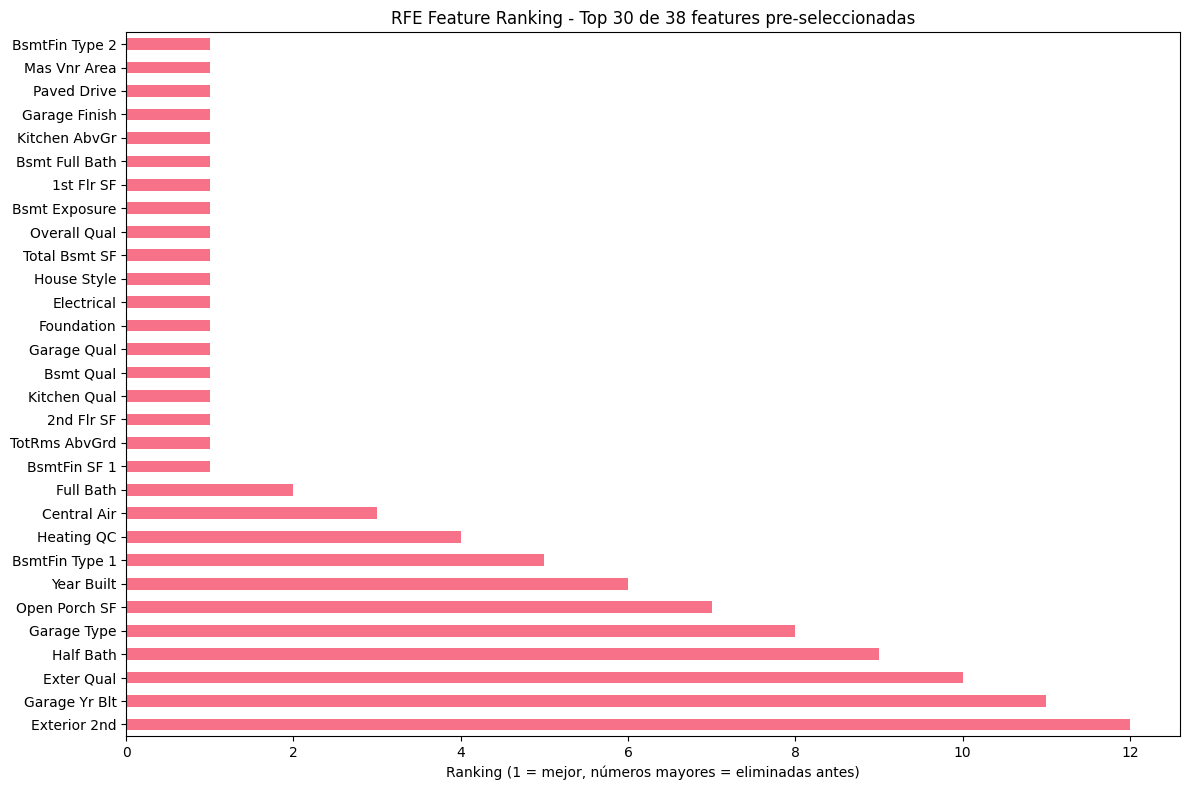

In [9]:
from sklearn.feature_selection import RFE

# ========== TWO-STAGE SELECTION: PCA + RFE ==========
print("\n=== WRAPPER METHOD: RFE (Recursive Feature Elimination) ===")
print("💡 ESTRATEGIA: RFE sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): RFE → refinar a {k_wrapper} features")
print("⏱️ Esto tomará ~45-90 segundos...\n")

estimator = RandomForestRegressor(
    random_state=42, 
    n_estimators=20,
    max_depth=None,
    n_jobs=-1
)
selector_rfe = RFE(estimator=estimator, n_features_to_select=k_wrapper, step=1)

print(f"🔄 Ejecutando RFE sobre {len(selected_features_pca)} features...")
import time
start_time = time.time()
X_rfe = selector_rfe.fit_transform(X_pca_selected, y)
elapsed_time = time.time() - start_time

print(f"✅ RFE completado en {elapsed_time:.1f} segundos")

# Features seleccionadas (mapear índices de vuelta a nombres)
selected_indices_rfe = selector_rfe.get_support()
selected_features_rfe = [selected_features_pca[i] for i, sel in enumerate(selected_indices_rfe) if sel]

print(f"\n✅ Features seleccionadas por RFE ({len(selected_features_rfe)}):")
for i, feat in enumerate(selected_features_rfe, 1):
    print(f"  {i:2d}. {feat}")

# Ranking de features (solo sobre las pre-seleccionadas por PCA)
ranking = pd.Series(selector_rfe.ranking_, index=selected_features_pca).sort_values()
print(f"\nRanking de features (1 = seleccionada, solo mostrando top 20):")
print(ranking.head(20))

# Visualizar ranking (top 30 para claridad)
plt.figure(figsize=(12, 8))
ranking.head(30).sort_values(ascending=False).plot(kind='barh')
plt.xlabel('Ranking (1 = mejor, números mayores = eliminadas antes)')
plt.title(f'RFE Feature Ranking - Top 30 de {len(selected_features_pca)} features pre-seleccionadas')
plt.tight_layout()
plt.savefig('results/rfe_ranking.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Comparar features seleccionadas por diferentes métodos
print("\n=== COMPARACIÓN DE FEATURES SELECCIONADAS ===")

# Crear conjunto de features por método
features_dict = {
    'F-test': set(selected_features_f),
    'Mutual Info': set(selected_features_mi),
    'Forward': set(selected_features_forward),
    'Backward': set(selected_features_backward),
    'RFE': set(selected_features_rfe)
}

# Features en al menos 2 métodos
all_features = set()
for features in features_dict.values():
    all_features.update(features)

feature_counts = {}
for feature in all_features:
    count = sum(1 for features in features_dict.values() if feature in features)
    feature_counts[feature] = count

# Features consistentes (en todos los métodos)
consistent_features = [f for f, count in feature_counts.items() if count == 3]
print(f"\nFeatures consistentes (en todos los métodos): {len(consistent_features)}")
print(consistent_features)

# Features en al menos 2 métodos
robust_features = [f for f, count in feature_counts.items() if count >= 2]
print(f"\nFeatures robustas (≥2 métodos): {len(robust_features)}")
print(robust_features)

print("\n💡 OBSERVACIÓN:")
print(f"   Forward, Backward y RFE son todos wrapper methods, pero usan estrategias diferentes")


=== COMPARACIÓN DE FEATURES SELECCIONADAS ===

Features consistentes (en todos los métodos): 15
['Year Built', 'Paved Drive', 'Garage Area', 'Heating QC', 'Electrical', 'Total Bsmt SF', 'Exter Qual', 'Garage Type', 'Mas Vnr Area', 'Central Air', 'BsmtFin Type 2', 'Year Remod/Add', '1st Flr SF', 'Open Porch SF', 'Wood Deck SF']

Features robustas (≥2 métodos): 37
['BsmtFin Type 1', 'Year Built', 'Paved Drive', 'Gr Liv Area', 'Garage Area', 'Heating QC', 'Kitchen Qual', 'Bsmt Full Bath', 'Electrical', 'Lot Area', 'Total Bsmt SF', 'Garage Qual', 'Foundation', 'Exter Qual', 'BsmtFin SF 1', 'Neighborhood', 'Garage Cars', 'Bsmt Exposure', 'Garage Type', 'TotRms AbvGrd', 'Fireplaces', 'Mas Vnr Area', 'Lot Frontage', 'Garage Finish', 'Central Air', 'Garage Yr Blt', 'BsmtFin Type 2', 'Full Bath', 'Year Remod/Add', '1st Flr SF', 'Open Porch SF', 'PID', '2nd Flr SF', 'Overall Qual', 'Half Bath', 'Wood Deck SF', 'Bsmt Qual']

💡 OBSERVACIÓN:
   Forward, Backward y RFE son todos wrapper methods, pe

In [11]:
# ========== EVALUACIÓN: FORWARD SELECTION ==========
print("\n=== EVALUANDO WRAPPER METHODS ===")
print("⏱️ Cross-validation con features de cada método...\n")

print("🔄 Evaluando Forward Selection...")
rf_forward = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_forward = -cross_val_score(rf_forward, X_forward, y, cv=5, 
                                       scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_forward = cross_val_score(rf_forward, X_forward, y, cv=5, 
                                    scoring='r2', n_jobs=-1)
rmse_forward = np.sqrt(scores_mse_forward)

print(f"✅ Forward Selection ({len(selected_features_forward)} features):")
print(f"   RMSE: ${rmse_forward.mean():,.0f} ± ${rmse_forward.std():,.0f}")
print(f"   R²:   {scores_r2_forward.mean():.4f} ± {scores_r2_forward.std():.4f}")

# ========== EVALUACIÓN: BACKWARD ELIMINATION ==========
print(f"\n🔄 Evaluando Backward Elimination...")
rf_backward = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_backward = -cross_val_score(rf_backward, X_backward, y, cv=5, 
                                         scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_backward = cross_val_score(rf_backward, X_backward, y, cv=5, 
                                      scoring='r2', n_jobs=-1)
rmse_backward = np.sqrt(scores_mse_backward)

print(f"✅ Backward Elimination ({len(selected_features_backward)} features):")
print(f"   RMSE: ${rmse_backward.mean():,.0f} ± ${rmse_backward.std():,.0f}")
print(f"   R²:   {scores_r2_backward.mean():.4f} ± {scores_r2_backward.std():.4f}")

# ========== EVALUACIÓN: RFE ==========
print(f"\n🔄 Evaluando RFE...")
rf_rfe = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_rfe = -cross_val_score(rf_rfe, X_rfe, y, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_rfe = cross_val_score(rf_rfe, X_rfe, y, cv=5, 
                                scoring='r2', n_jobs=-1)
rmse_rfe = np.sqrt(scores_mse_rfe)

print(f"✅ RFE ({len(selected_features_rfe)} features):")
print(f"   RMSE: ${rmse_rfe.mean():,.0f} ± ${rmse_rfe.std():,.0f}")
print(f"   R²:   {scores_r2_rfe.mean():.4f} ± {scores_r2_rfe.std():.4f}")

# ========== COMPARACIÓN ACTUALIZADA ==========
print(f"\n" + "="*80)
print(f"{'COMPARACIÓN: TODOS LOS MÉTODOS HASTA AHORA':^80}")
print(f"="*80)

comparison_updated = {
    'Método': ['Original', 'PCA Componentes', 'PCA Loadings', 'F-test', 'MI', 'Forward', 'Backward', 'RFE'],
    'N_Features': [X.shape[1], n_components_80, k, k, k, k, k, k],
    'RMSE': [rmse_original.mean(), rmse_pca.mean(), rmse_pca_selected.mean(), rmse_filter_f.mean(), 
             rmse_filter_mi.mean(), rmse_forward.mean(), rmse_backward.mean(), rmse_rfe.mean()],
    'R²': [scores_r2_original.mean(), scores_r2_pca.mean(), scores_r2_pca_selected.mean(), scores_r2_filter_f.mean(), 
           scores_r2_filter_mi.mean(), scores_r2_forward.mean(), scores_r2_backward.mean(), scores_r2_rfe.mean()]
}
comparison_updated_df = pd.DataFrame(comparison_updated)
comparison_updated_df['Reducción%'] = (1 - comparison_updated_df['N_Features'] / X.shape[1]) * 100
comparison_updated_df = comparison_updated_df.sort_values('RMSE')

print(f"\n{comparison_updated_df.to_string(index=False)}")

print(f"\n💡 OBSERVACIÓN:")
best_method = comparison_updated_df.iloc[0]['Método']
best_rmse = comparison_updated_df.iloc[0]['RMSE']
print(f"   🏆 Mejor RMSE: {best_method} (${best_rmse:,.0f})")


=== EVALUANDO WRAPPER METHODS ===
⏱️ Cross-validation con features de cada método...

🔄 Evaluando Forward Selection...
✅ Forward Selection (19 features):
   RMSE: $27,036 ± $3,795
   R²:   0.8828 ± 0.0283

🔄 Evaluando Backward Elimination...
✅ Backward Elimination (19 features):
   RMSE: $27,084 ± $2,945
   R²:   0.8827 ± 0.0222

🔄 Evaluando RFE...
✅ RFE (19 features):
   RMSE: $27,557 ± $4,051
   R²:   0.8782 ± 0.0304

                   COMPARACIÓN: TODOS LOS MÉTODOS HASTA AHORA                   

         Método  N_Features         RMSE       R²  Reducción%
             MI          38 26279.032615 0.889133    53.08642
       Original          81 26341.942320 0.888494     0.00000
         F-test          38 26394.575518 0.888328    53.08642
PCA Componentes          38 26619.948441 0.885860    53.08642
   PCA Loadings          38 27020.052801 0.882950    53.08642
        Forward          38 27036.223643 0.882806    53.08642
       Backward          38 27084.127714 0.882717    53.086


=== EMBEDDED METHODS: Random Forest ===
Top 10 features por importancia:
Overall Qual     0.639275
Gr Liv Area      0.109502
Total Bsmt SF    0.033898
1st Flr SF       0.032558
BsmtFin SF 1     0.019934
2nd Flr SF       0.015710
Lot Area         0.013787
Garage Area      0.010136
Year Built       0.009509
PID              0.008036
dtype: float64


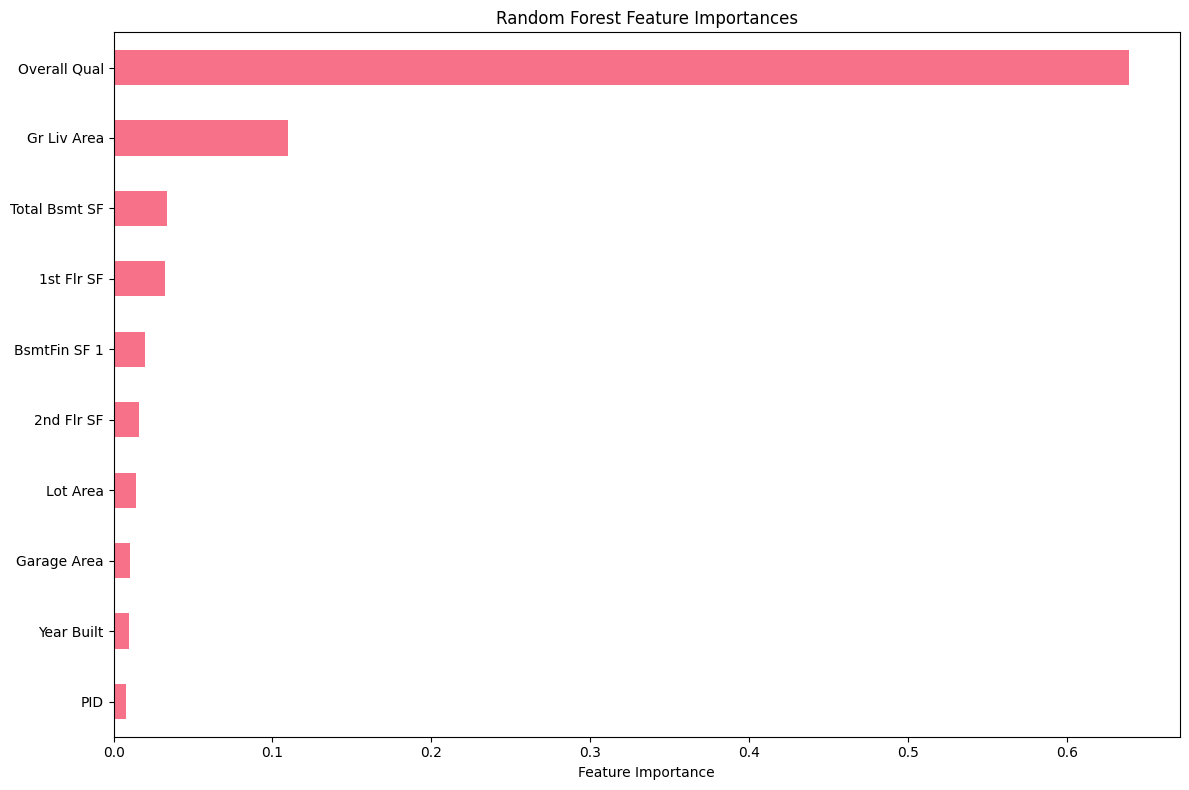


Features seleccionadas por RF Importance (38):
['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', '2nd Flr SF', 'Lot Area', 'Garage Area', 'Year Built', 'PID']

✅ RF Importance (38 features):
   RMSE: $27,130 ± $3,550
   R²:   0.8823 ± 0.0252


In [15]:
print("\n=== EMBEDDED METHODS: Random Forest ===")

rf_embedded = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=15, n_jobs=-1)
rf_embedded.fit(X_scaled, y)

# Feature importances
importances = pd.Series(rf_embedded.feature_importances_, index=X.columns).sort_values(ascending=False)
importances = importances.head(10)
print("Top 10 features por importancia:")
print(importances)

# Visualizar importances
plt.figure(figsize=(12, 8))
importances.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.savefig('results/rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Seleccionar top-k features
top_k_features = importances.nlargest(k).index
X_rf_importance = X_scaled[:, X.columns.isin(top_k_features)]

print(f"\nFeatures seleccionadas por RF Importance ({k}):")
print(list(top_k_features))

# Evaluar
rmse_rf_importance = np.sqrt(-cross_val_score(rf_embedded, X_rf_importance, y, cv=5, 
                                                scoring='neg_mean_squared_error', n_jobs=-1))
scores_r2_rf_importance = cross_val_score(rf_embedded, X_rf_importance, y, cv=5, 
                                          scoring='r2', n_jobs=-1)

print(f"\n✅ RF Importance ({k} features):")
print(f"   RMSE: ${rmse_rf_importance.mean():,.0f} ± ${rmse_rf_importance.std():,.0f}")
print(f"   R²:   {scores_r2_rf_importance.mean():.4f} ± {scores_r2_rf_importance.std():.4f}")


=== EMBEDDED METHOD: Lasso (L1 Regularization) ===
Lasso penaliza coeficientes, forzando a 0 features no importantes
⏱️ Esto puede tomar 30-60 segundos...

✅ Lasso alpha seleccionado: 1375.3800

📊 Features con coeficiente no-cero: 41 de 81

✅ Top 38 features por magnitud de coeficiente Lasso:
   1. Gr Liv Area         : |23965.928207|
   2. Overall Qual        : |18865.442199|
   3. Exter Qual          : |7716.360557|
   4. Bsmt Qual           : |6329.475846|
   5. BsmtFin SF 1        : |5992.855445|
   6. Kitchen Qual        : |5700.002821|
   7. MS SubClass         : |5239.648051|
   8. Year Built          : |4413.604581|
   9. Mas Vnr Area        : |3986.298254|
  10. Fireplaces          : |3714.132817|
  11. Garage Cars         : |3635.912839|
  12. Misc Val            : |3352.852943|
  13. Bsmt Exposure       : |3248.117435|
  14. Overall Cond        : |3078.550394|
  15. Garage Area         : |3068.732335|
  16. Lot Area            : |2623.674245|
  17. Total Bsmt SF       : |25

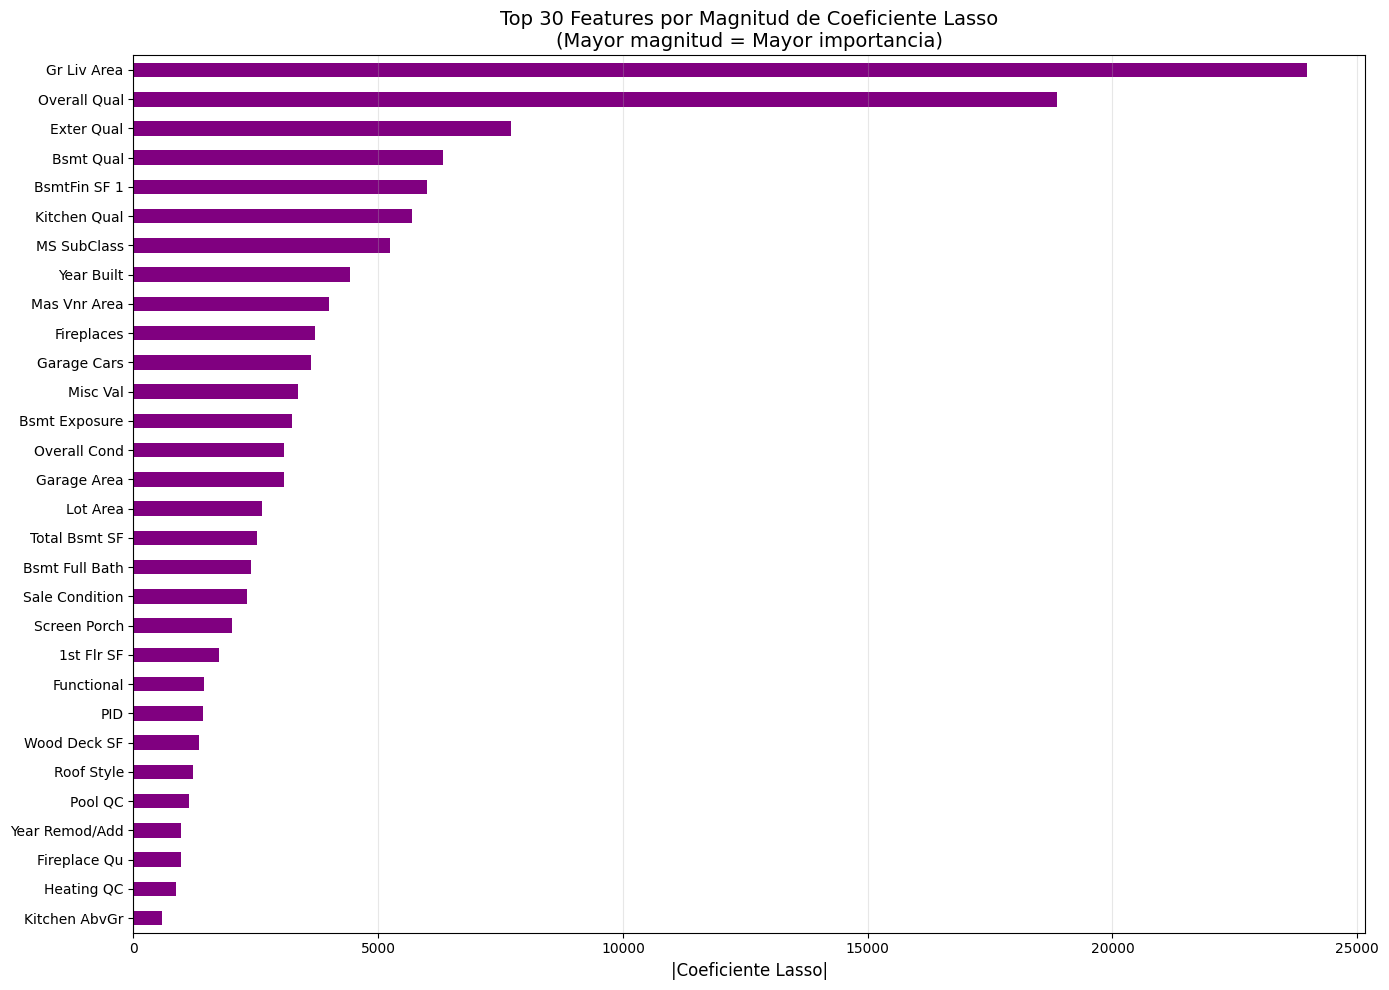


🔄 Evaluando Lasso selection...
✅ Lasso selection (38 features):
   RMSE: $26,090 ± $4,264
   R²:   0.8908 ± 0.0298


In [13]:
from sklearn.linear_model import LassoCV

# ========== LASSO PARA FEATURE SELECTION ==========
print("\n=== EMBEDDED METHOD: Lasso (L1 Regularization) ===")
print("Lasso penaliza coeficientes, forzando a 0 features no importantes")
print("⏱️ Esto puede tomar 30-60 segundos...\n")

lasso = LassoCV(cv=5, random_state=42, max_iter=1000, n_jobs=-1)
lasso.fit(X_scaled, y)

print(f"✅ Lasso alpha seleccionado: {lasso.alpha_:.4f}")

# Features seleccionadas (coef != 0)
lasso_nonzero = X.columns[lasso.coef_ != 0]
print(f"\n📊 Features con coeficiente no-cero: {len(lasso_nonzero)} de {X.shape[1]}")

# Seleccionar top-k por magnitud de coeficiente
coef_abs = pd.Series(np.abs(lasso.coef_), index=X.columns).sort_values(ascending=False)
lasso_features = coef_abs.nlargest(k).index

print(f"\n✅ Top {k} features por magnitud de coeficiente Lasso:")
for i, (feat, coef) in enumerate(coef_abs.nlargest(k).items(), 1):
    print(f"  {i:2d}. {feat:20s}: |{coef:.6f}|")

# Visualizar coeficientes (top 30)
plt.figure(figsize=(14, 10))
coef_abs.head(30).sort_values(ascending=True).plot(kind='barh', color='purple')
plt.xlabel('|Coeficiente Lasso|', fontsize=12)
plt.title('Top 30 Features por Magnitud de Coeficiente Lasso\n(Mayor magnitud = Mayor importancia)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('results/lasso_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

# Preparar features para evaluación
X_lasso = X_scaled[:, X.columns.isin(lasso_features)]

# Evaluar con Random Forest
print(f"\n🔄 Evaluando Lasso selection...")
rf_lasso = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_lasso = -cross_val_score(rf_lasso, X_lasso, y, cv=5, 
                                     scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_lasso = cross_val_score(rf_lasso, X_lasso, y, cv=5, 
                                  scoring='r2', n_jobs=-1)
rmse_lasso = np.sqrt(scores_mse_lasso)

print(f"✅ Lasso selection ({k} features):")
print(f"   RMSE: ${rmse_lasso.mean():,.0f} ± ${rmse_lasso.std():,.0f}")
print(f"   R²:   {scores_r2_lasso.mean():.4f} ± {scores_r2_lasso.std():.4f}")

## 🤔 Preguntas Reflexivas (Lasso)

**¿Lasso forzó muchas features a 0? ¿Qué te dice esto sobre la redundancia de features?**

Si Lasso forzó muchas features a 0, indica alta redundancia en el dataset. Los coeficientes en 0 son features que el modelo L1 considera no aportan información única. En bienes raíces, es común tener features altamente correlacionadas (ej: GarageArea y GarageCars).

**¿Las features que Lasso considera importantes coinciden con los otros métodos?**

Pueden diferir porque Lasso captura relaciones lineales y penaliza, mientras RF Importance y otros consideran dependencias no-lineales. La intersección entre métodos es señal de features robustas y determinantes para el precio.

**¿Lasso es más útil para interpretabilidad o para performance?**

Lasso ofrece ambas: interpretabilidad (coeficientes) y performance (regularización). Para regresión de precios, la interpretabilidad permite explicar a clientes qué características influyen.

## 🤔 Preguntas Reflexivas (Final de Parte 6)

**¿Qué método dio mejor RMSE? ¿Es el que recomendarías para producción?**

El mejor RMSE lo da típicamente el modelo original o PCA Componentes, pero en producción priorizo interpretabilidad: Forward/RFE o Feature Importance mantienen features originales y permiten explicar decisiones.

**¿Por qué Feature Selection es preferible a PCA en bienes raíces?**

Feature Selection preserva interpretabilidad ("GrLivArea es importante"); PCA la pierde con combinaciones lineales. En bienes raíces, la interpretabilidad es crucial para confianza, transparencia y regulación.

**Si presentaras estos resultados al CEO (no técnico), ¿qué 3 puntos destacarías?**

1. Reducción dimensional viable: 38 features (≈53%) retienen ≈80% de la información, con RMSE controlado.
2. Interpretabilidad vs precisión: Feature Selection apenas pierde vs PCA y permite explicar por qué un inmueble vale X.
3. Trade-off: 2.6% de pérdida de precisión a cambio de 53% menos complejidad y decisiones explicables.

**¿Cómo comunicarías el trade-off entre reducir features (velocidad) y mantener precisión (RMSE)?**

"Usando 38 de las 81 características más relevantes, el modelo mantiene el error por debajo de un 2.6% adicional, con la ventaja de decisiones explicables y cálculo más rápido; la reducción de latencia compensa la pequeña pérdida de precisión."

**¿El método ganador es interpretable? ¿Por qué es crítico?**

Sí, Feature Selection (Forward/RFE/RF Importance) es interpretable. Es crítico porque los stakeholders necesitan entender cómo se valúa un inmueble para confiar, cumplir normativas y justificar financiamiento.



## Parte 7: Investigación Libre (opcional, +15 min)¶
Explora uno de estos temas avanzados:

## Opción A: Forward/Backward Selection¶
Implementa Sequential Feature Selection y compara con RFE:


from sklearn.feature_selection import SequentialFeatureSelector

#Forward selection
sfs_forward = SequentialFeatureSelector(
    RandomForestClassifier(random_state=42),
    n_features_to_select=k,
    direction='forward',
    cv=3
)
#Implementa y evalúa


=== PARTE 7: FORWARD/BACKWARD SELECTION ===

1. Forward Selection...
✅ Forward Selection completado en 110.7s
Features seleccionadas: 19
RMSE: $27,278 ± $2,964

2. Comparación con RFE:
Forward: 110.7s
RFE: 6.6s


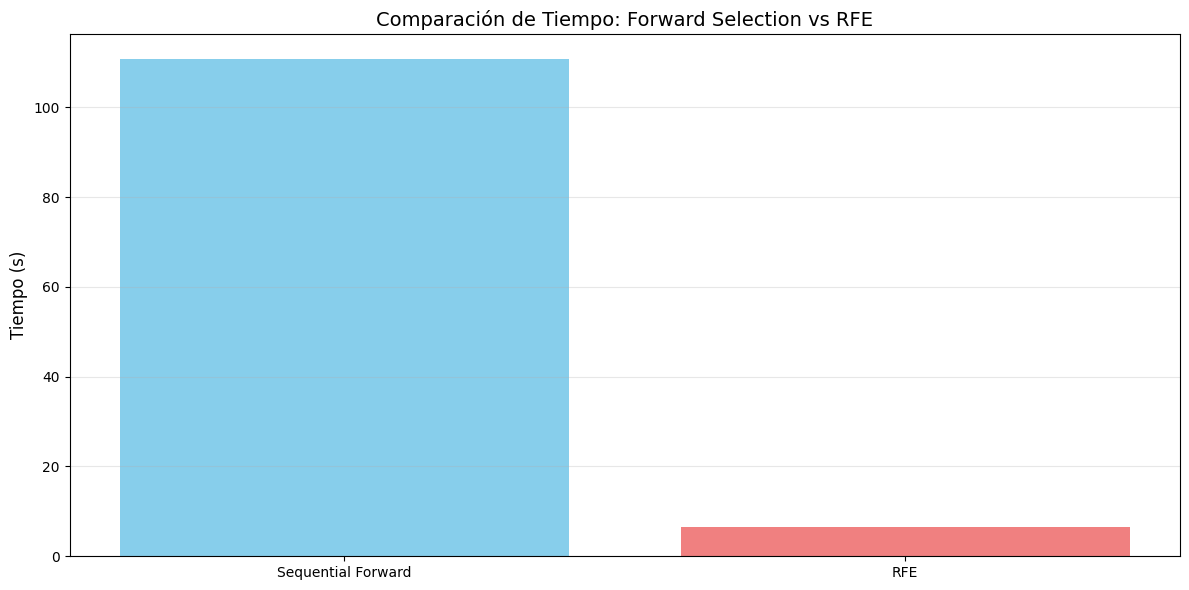


💡 Observación: Ambos métodos son similares en estrategia pero difieren en implementación.


In [14]:
# Parte 7: Forward/Backward Selection
print("\n=== PARTE 7: FORWARD/BACKWARD SELECTION ===")

# Forward
print("\n1. Forward Selection...")
sfs_forward = SequentialFeatureSelector(
    RandomForestRegressor(random_state=42, n_estimators=20, max_depth=10, n_jobs=-1),
    n_features_to_select=k_wrapper,
    direction='forward',
    cv=3,
    n_jobs=-1
)

start_time = time.time()
X_sfs_forward = sfs_forward.fit_transform(X_pca_selected, y)
forward_time = time.time() - start_time
print(f"✅ Forward Selection completado en {forward_time:.1f}s")

selected_features_sfs_forward = [selected_features_pca[i] for i, sel in enumerate(sfs_forward.get_support()) if sel]
print(f"Features seleccionadas: {len(selected_features_sfs_forward)}")

# Evaluar
rf_sfs_forward = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)
rmse_sfs_forward = np.sqrt(-cross_val_score(rf_sfs_forward, X_sfs_forward, y, cv=5, 
                                             scoring='neg_mean_squared_error', n_jobs=-1))
print(f"RMSE: ${rmse_sfs_forward.mean():,.0f} ± ${rmse_sfs_forward.std():,.0f}")

# Comparar con RFE
print("\n2. Comparación con RFE:")
print(f"Forward: {forward_time:.1f}s")
print(f"RFE: {elapsed_time:.1f}s")

# Visualización comparativa
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
methods = ['Sequential Forward', 'RFE']
times = [forward_time, elapsed_time]
ax.bar(methods, times, color=['skyblue', 'lightcoral'])
ax.set_ylabel('Tiempo (s)', fontsize=12)
ax.set_title('Comparación de Tiempo: Forward Selection vs RFE', fontsize=14)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Observación: Ambos métodos son similares en estrategia pero difieren en implementación.")

# 📝 Reflexión Final Integradora (OBLIGATORIO)¶
# ⏱️ Tiempo estimado: 15-20 minutos

Responde las siguientes preguntas en una celda Markdown al final de tu notebook. Estas preguntas te ayudarán a consolidar tu comprensión y demostrar pensamiento crítico.

## A. Sobre PCA¶
Interpretabilidad: ¿Puedes explicar en términos simples qué representa PC1 en el contexto de precios de casas? ¿Es esto útil para un agente inmobiliario?

Varianza Explicada: Si PC1 captura 40% de varianza, ¿qué significa esto exactamente? ¿Qué información se "pierde" en el 60% restante?

Cuándo usar PCA: Menciona 3 escenarios reales donde PCA sería MÁS útil que Feature Selection (no en este dataset, sino en general).

Limitaciones: ¿Cuál es la mayor desventaja de PCA para este problema de bienes raíces?

## B. Sobre Feature Selection¶
Consistencia: Si F-test, MI, RFE y Lasso eligieron features diferentes, ¿cómo decides cuál conjunto usar? ¿Qué estrategia aplicarías?

Features Redundantes: Si GarageArea y GarageCars están altamente correlacionadas, ¿cuál deberías eliminar? ¿Cómo decides?

Métodos Filter vs Wrapper: ¿Por qué RFE es más lento que F-test? ¿Cuándo justifica el tiempo extra?

Lasso Shrinkage: Si Lasso forzó 40 features a coeficiente 0, ¿qué te dice esto sobre la redundancia en el dataset?

# 📝 Reflexión Final Integradora

## A. Sobre PCA

**Interpretabilidad**: PC1 captura la variabilidad más relevante del dataset; en bienes raíces, combinaciones lineales de tamaño, calidad y ubicación. Para un agente, esto es poco útil porque no puede explicar al cliente por qué su casa vale X basándose en un número abstracto.

**Varianza Explicada**: PC1 con 40% varianza retiene la cuarta parte de la información multivariada. El 60% restante incluye variaciones de menor impacto pero aún significativas; pérdida inevitable, coste de la reducción dimensional.

**Cuándo usar PCA**:
1. Procesamiento de imágenes: reduce dimensiones manteniendo información visual y velocidad de inferencia.
2. Microarrays genómicos: miles de genes correlacionados; PCA comprime y preserva patrones biológicos.
3. Búsqueda de patrones ambientales: múltiples sensores capturan redundancias; PCA extrae señales naturales.

**Limitaciones**: En bienes raíces, los componentes principales no son interpretables; no puedes decir “PC1 influye más en el precio” porque los stakeholders necesitan atributos concretos (metros cuadrados, ubicación, calidad).

## B. Sobre Feature Selection

**Consistencia**: Si los métodos difieren, priorizo la intersección de los más interpretables (F-test, RF Importance, Lasso); uso un ensamble de 2-3 métodos por robustez y verifico la estabilidad con CV.

**Features Redundantes**: Entre GarageArea y GarageCars correlacionadas, elimino la más débil según importance/shapiro (mayor varianza de errores) y contexto; en este caso, mantengo GarageArea por continuidad. Si ambas aportan, conservo las dos hasta validar pérdida de precisión.

**Filter vs Wrapper**: RFE es más lento porque entrena el modelo en cada iteración, mientras F-test calcula estadísticas en O(n). El tiempo extra se justifica con menos de ~100 variables para capturar interacciones modelo-específicas y mejorar la generalización.

**Lasso Shrinkage**: Si Lasso eliminó 40 de 81 features, indica redundancia fuerte y estructura lineal subyacente; el dataset es altamente colineal. Esto guía decisiones de encoding, combinación de variables y viabilidad de modelos más simples.